### Visualize the Scattering and Attenuation Effect

In [1]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import polygon, polygon2mask
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt

import os
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import arr_info
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair, 
                       vis_triple)

In [2]:
#If it's a multi-channel image, try to get it in [0,255]
def to_single_channel(I):
    if (len(I.shape) > 2):
        Ig = 0.2989 * I[..., 0] + 0.5870 * I[..., 1] + 0.1140 * I[..., 2]
        I = Ig

        I = I/I.ravel().max()
        I = 255*I
        I = np.round(I)
        I[I>255] = 255
        I = I.copy().astype('uint8')
        return I

In [3]:
def atten_effect(path):
    img = plt.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    bottom = np.where(markers==2)[0].max()
    left = np.where(markers==2)[1].min()
    
    # Some threshold values
    vert_thres = 500
    horz_thres = 50
    length = 80
    dist = 350
    
    # Avoid Extracting incorrect ROI
    while markers[bottom-vert_thres, left+horz_thres] == 1:
        left += horz_thres
    left
    coord_left = np.array([[bottom, left+horz_thres], [bottom, left+horz_thres+length], 
                       [bottom-vert_thres, left+horz_thres+length], 
                       [bottom-vert_thres, left+horz_thres]])
    coord_right = np.array([[bottom, left+horz_thres+dist], [bottom, left+horz_thres+dist+length], 
                        [bottom-vert_thres, left+horz_thres+dist+length], 
                        [bottom-vert_thres, left+horz_thres+dist]])
    I_left = img[coord_left[:,0][0]:coord_left[:,0][2], coord_left[:,1][0]:coord_left[:,1][2]]
    I_right = img[coord_right[:,0][0]:coord_right[:,0][2], coord_right[:,1][0]:coord_right[:,1][2]]
    rrl, ccl = polygon(coord_left[:,0], coord_left[:,1], shape=img.shape[:2])
    rrr, ccr = polygon(coord_right[:,0], coord_right[:,1], shape=img.shape[:2])
    mask_l = np.zeros(img.shape[:2])
    mask_l[rrl,ccl] = 1
    mask_r = np.zeros(img.shape[:2])
    mask_r[rrr, ccr] = 1
    img = to_single_channel(img)
    arr_info(img)
    x = []
    x1 = []
    y = []
    y1 = []
    for i in range(bottom, bottom-vert_thres, -1):
        x.append(i)
        y.append(np.mean(img[i-1:i, left+horz_thres:left+horz_thres+length]))
    for i in range(bottom, bottom-vert_thres, -1):
        x1.append(i)
        y1.append(np.mean(img[i-1:i, left+horz_thres+dist:left+horz_thres+dist+length]))
    x = np.array(x)
    x1 = np.array(x1)
    y = np.array(y)
    y1 = np.array(y1)
    return 1700-x1, y1

In [4]:
path1 = '../stacked_new/NTU108.jpg'
path2 = '../stacked_new/NTU123.jpg'
path3 = '../stacked_new/NTU142.jpg'
a1, a2 = atten_effect(path1)
b1, b2 = atten_effect(path2)
c1, c2 = atten_effect(path3)

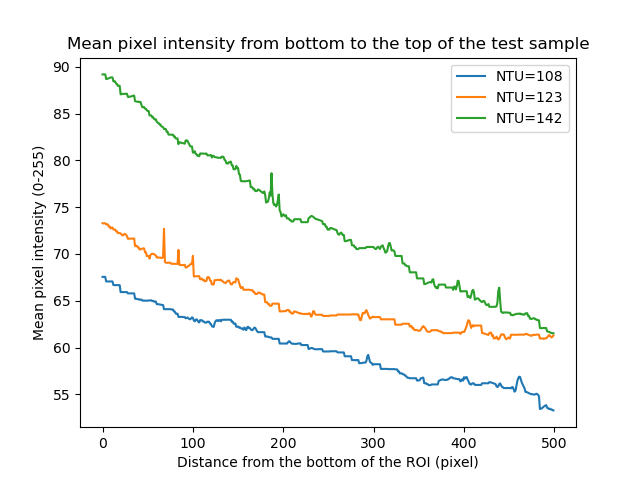

In [5]:
# Figure 7
plt.figure()
plt.plot(a1,a2,label='NTU=108')
plt.plot(b1,b2,label='NTU=123')
plt.plot(c1,c2,label='NTU=142')
plt.title("Mean pixel intensity from bottom to the top of the test sample")
plt.xlabel("Distance from the bottom of the ROI (pixel)")
plt.ylabel("Mean pixel intensity (0-255)")
plt.legend()
plt.show()

In [6]:
plt.savefig('../assets/atten_effect.pdf', dpi=600)

In [7]:
path1 = '../stacked_new/NTU108.jpg'
img = plt.imread(path1)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

In [8]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

In [9]:
markers = markers+1
markers[unknown==255] = 0
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)

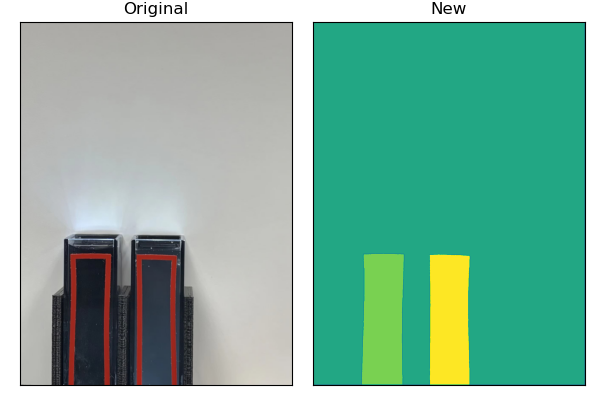

In [10]:
vis_pair(img, markers)

In [11]:
plt.savefig('../assets/watershed.pdf', dpi=600)